# Обучение предиктивных моделей на датасете "total"

**Цели и задачи:**<br>
Проверка результатов прогнозирования моделей "_**CatBoost**_" и "_**XGBoost**_" на датасете с сокращенным количеством переменных (датасет типа "total").

In [21]:
## Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

## 1. Подготовка датасета для обучения и тестирования

### 1.1 Датасет типа "total"

In [22]:
## Чтение данных из файла
weather = pd.read_csv('DATA/weather_data_total4.csv.gz', compression='gzip', header=0, sep=';'
                      , quotechar='"')
municip = pd.read_csv('INPUT/id_муниципалитета.csv.zip', compression='zip', header=0, sep=';'
                      , dtype={'digit_id': 'object'}, quotechar='"')
settl = pd.read_csv('DATA/Settlement_Id.zip', compression='zip', header=0, sep=';'
                    , dtype={'digit_id': 'object'}, quotechar='"')
target = pd.read_csv('INPUT/target.csv.zip', compression='zip', header=0, sep=';', decimal=','
                     , dtype={'digit_id': 'object'}, quotechar='"')
diff_trend = pd.read_csv('DATA/data_ssa.csv.gz', compression='gzip', header=0, sep=';'
                         , dtype={'yield_code': 'object'}, quotechar='"')

In [23]:
## Добавление id метеостанций к фрейму с целевой переменной
# добавление данных по урожайности и накопленного тренда урожайности
target = target.loc[~target['check'].isin([0])]
target['triplet'] = target['digit_id'].astype(str).str[:3]
target['solo'] = target['digit_id'].astype(str).str[0]+'00'
diff_trend = diff_trend.loc[pd.notnull(diff_trend['diff_cumulative']), ['year', 'yield_code', 'diff_cumulative']]
# создание массива по урожайности
target = pd.merge(target, diff_trend, how='left', left_on=['year', 'triplet'], right_on=['year', 'yield_code'])
target = pd.merge(target, diff_trend, how='left', left_on=['year', 'solo'], right_on=['year', 'yield_code'])

# очистка урожайности от тренда
target['trendless'] = np.nan
target.loc[pd.isnull(target['trendless']), 'trendless'] = target.loc[pd.isnull(target['trendless']), 'yield'] - target.loc[pd.isnull(target['trendless']), 'diff_cumulative_x']
target.loc[pd.isnull(target['trendless']), 'trendless'] = target.loc[pd.isnull(target['trendless']), 'yield'] - target.loc[pd.isnull(target['trendless']), 'diff_cumulative_y']
target.dropna(subset=['trendless'], inplace=True)
target = target[['digit_id', 'year', 'federal_distr', 'region', 'category', 'trendless']]

# добавление данных по метеостанциям
meteo = settl[['digit_id', 'meteoid']].drop_duplicates()
target = pd.merge(target, meteo, how='left', on=['digit_id'])

# добавление данных с идентификаторами муниципалитетов
target = pd.merge(target, municip[['digit_id', 'id_municip']], how='left', on=['digit_id'])
target.drop_duplicates(keep='first', inplace=True, ignore_index=True) # удаление дубликатов

In [24]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48068 entries, 0 to 48067
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   digit_id       48068 non-null  object 
 1   year           48068 non-null  int64  
 2   federal_distr  48068 non-null  object 
 3   region         48068 non-null  object 
 4   category       48068 non-null  object 
 5   trendless      48068 non-null  float64
 6   meteoid        48068 non-null  int64  
 7   id_municip     48068 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 2.9+ MB


In [25]:
## Средние значения показателей для заполнения значений Nan
geolocation = settl.groupby(['digit_id']).agg(
    north_border = pd.NamedAgg(column = 'latitude', aggfunc = 'max'),
    south_border = pd.NamedAgg(column = 'latitude', aggfunc = 'min'),
    east_border = pd.NamedAgg(column = 'longitude', aggfunc = 'max'),
    west_border = pd.NamedAgg(column = 'longitude', aggfunc = 'min'),
    central_lat = pd.NamedAgg(column = 'latitude', aggfunc = 'mean'),
    central_lon = pd.NamedAgg(column = 'longitude', aggfunc = 'mean'),
    settl_count = pd.NamedAgg(column = 'settlement', aggfunc = 'count')
)
geolocation.reset_index(inplace=True) # перевод индексов группировки в столбцы
target = pd.merge(target, geolocation, how='left', on=['digit_id'])

In [26]:
## Создание учебного датафрейма
target['rotation'] = target['year']%4 # добавление фичи по севообороту
target.drop(columns=['digit_id'], inplace=True)
data = pd.merge(weather, target, how='right', on=['year', 'meteoid'])
data.drop_duplicates(keep='first', inplace=True, ignore_index=True)
data.dropna(axis=0, how='any', inplace=True)
#data['region_id'] = data['region_id'].astype(int)
data.rename(columns={"trendless": "target"}, inplace=True)

In [27]:
## Список неинформативных столбцов
antitop = [
    'min_baric_tendency',
    'min_u_humidity',
    'max_baric_tendency',
    'max_wind_speed',
    'max_wind_gust_between',
    'diff_cloudiness',
    'max_height_clouds',
    'diff_height_clouds',
    'min_cloudiness',
    'min_height_clouds',
    'min_wind_speed'
]

In [28]:
## Удаление неинформативных столбцов из датафрейма total (для датафрейма "weather_data_total4.csv.gz")
# создание списка неинформативных столбцов
drop_col_tot = []

for items in antitop:
    c = 'total_{}'.format(items)
    drop_col_tot.append(c)

data.drop(columns=drop_col_tot, inplace=True)

In [29]:
data = data.loc[(data['category'] !='КФХ')]
## Преобразование категориальных переменных признака "category" в числовые значения
le = LabelEncoder() # метод преобразования категориальных признаков
# преобразование в числовые значения
data['category'] = le.fit_transform(data['category'])
data['federal_distr'] = le.fit_transform(data['federal_distr'])
data['region'] = le.fit_transform(data['region'])

In [30]:
## Удаление лишних данных
del settl
del meteo
del weather
del municip

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31248 entries, 13361 to 48067
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          31248 non-null  float64
 1   meteoid                       31248 non-null  int64  
 2   total_min_air_temp            31248 non-null  float64
 3   total_min_ground_temp         31248 non-null  float64
 4   total_min_po_press            31248 non-null  float64
 5   total_max_air_temp            31248 non-null  float64
 6   total_max_po_press            31248 non-null  float64
 7   total_max_u_humidity          31248 non-null  float64
 8   total_max_cloudiness          31248 non-null  float64
 9   total_avg_air_temp            31248 non-null  float64
 10  total_avg_po_press            31248 non-null  float64
 11  total_avg_baric_tendency      31248 non-null  float64
 12  total_wind_rumb_radians       31248 non-null  float64
 1

In [32]:
## Формирование датасета и вектора целевой переменной
train_data = data.copy()
train_label = data['target']

# удаление лишних столбцов
train_data = train_data.drop(columns=['year', 'meteoid', 'target'])

In [33]:
# разделение выборки на обучающую и тестовую (80/20) 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [34]:
category = ['category', 'federal_distr', 'region', 'rotation']

train_data = Pool(data=X_train,
                  label= y_train,
                  cat_features=category)

test_data = Pool(data=X_test,
                 cat_features=category)

eval_data = Pool(data=X_test,
                 label= y_test,
                 cat_features=category)

## 2. Обучение и тестирование моделей CatBoost regressor

### 2.1 Обучение модели на общих данных (по муниципалитетам всех регионов)

#### 2.1.1 Обучение модели CatBoost Regressor

In [35]:
# инициализация модели
cat_tot = CatBoostRegressor(iterations=5000,
                            loss_function="RMSE",
                            verbose=False,
                            depth=6,
                            l2_leaf_reg=0.71,
                            learning_rate=0.0750,
                            max_leaves=64,
                            boosting_type="Ordered",
                            random_seed=2)
# обучение модели
cat_tot.fit(train_data,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
# Прогнозирование модели CatBoost
cat_pred_tot = cat_tot.predict(test_data)
# Вычисление RMSE 
cat_rmse_tot = mean_squared_error(y_test, cat_pred_tot, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse_tot))

CatBoost RMSE :  2.634793


In [39]:
importance = cat_tot.feature_importances_
features = X_test.columns
feature_importance = pd.DataFrame(zip(features,importance), columns=['features', 'importance'])
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.head(50)

,features,importance
31,region,14.199440
33,id_municip,8.224578
39,central_lon,7.768136
35,south_border,7.312659
34,north_border,7.111188
36,east_border,6.350677
37,west_border,5.991879
40,settl_count,5.876669
38,central_lat,4.449066
41,rotation,3.344580


Text(0.5, 1.0, 'Feature Importance')

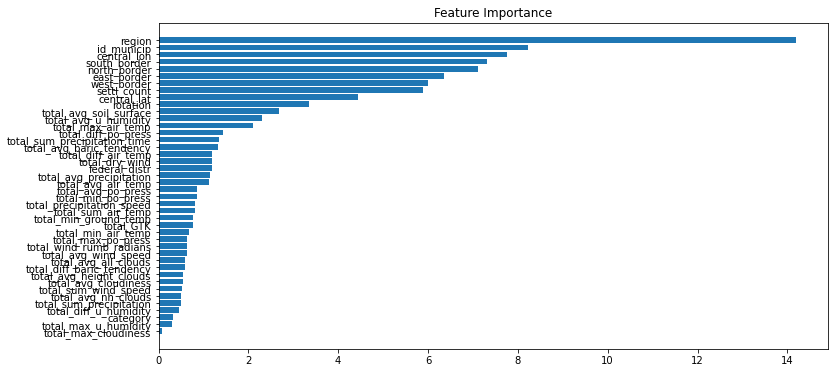

In [40]:
feature_importance = cat_tot.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [41]:
print(cat_tot.get_best_score())

{'learn': {'RMSE': 2.0010410559411294}}


In [42]:
cat_tot.save_model('RESULTS/MODELS/cat_all_regions_tot', format="cbm")

#### 2.1.2 Обучение модели XGBoost Regressor

In [43]:
# Модель с оптимизированными параметрами модели
xgb_all_regions = xgb.XGBRegressor(objective='reg:squarederror',
                                   random_state=2,
                                   learning_rate=0.075,
                                   max_depth=10,
                                   min_child_weight=1,
                                   subsample=1,
                                   colsample_bytree=0.6,
                                   gamma=0.05,
                                   n_estimators=5000) 

# Обучение модели
xgb_all_regions.fit(X_train, y_train)

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.075, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
# Прогнозирование модели XGBoost
xgb_pred_tot = xgb_all_regions.predict(X_test)
# Вычисление RMSE 
xgb_rmse_tot = mean_squared_error(y_test, xgb_pred_tot, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse_tot))

XGBoost RMSE :  2.021981


In [45]:
importance = xgb_all_regions.feature_importances_
features = X_test.columns
feature_importance = pd.DataFrame(zip(features,importance), columns=['features', 'importance'])
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.head(30)

,features,importance
31,region,0.111339
36,east_border,0.079826
41,rotation,0.079786
39,central_lon,0.074000
37,west_border,0.053757
33,id_municip,0.047669
30,federal_distr,0.034836
38,central_lat,0.034536
11,total_avg_u_humidity,0.028254
34,north_border,0.027703


Text(0.5, 1.0, 'Feature Importance')

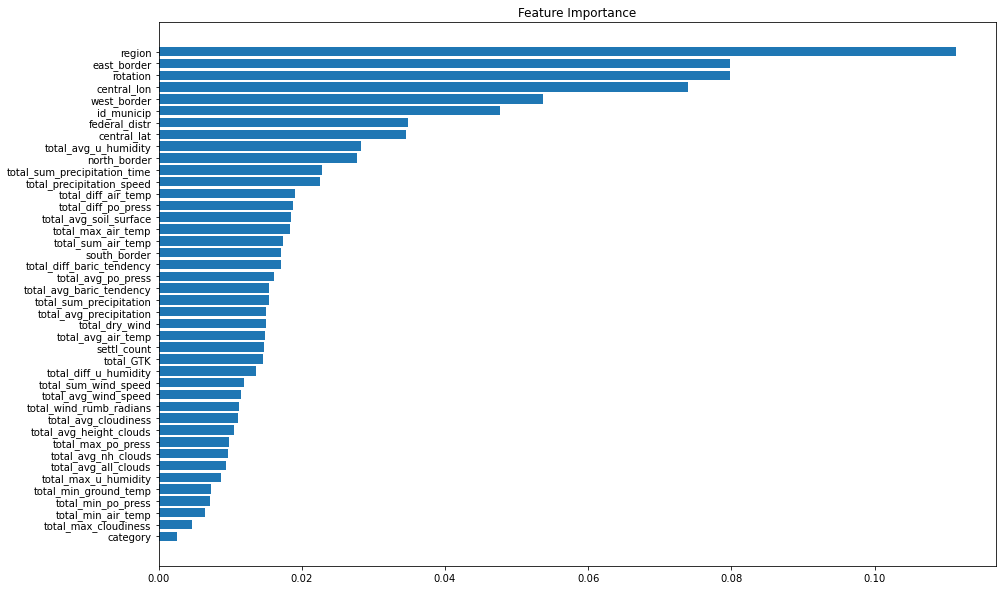

In [46]:
feature_importance = xgb_all_regions.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [47]:
xgb_all_regions.save_model("RESULTS/MODELS/xgb_all_regions_tot.json")

### 2.2 Обучение модели на данных по регионам (по муниципалитетам отдельного региона)

#### 2.2.1 Обучение модели CatBoost Regressor

In [48]:
## Инициализация модели оптимизированными параметрами
cat = CatBoostRegressor(iterations=5000,
                        loss_function="RMSE",
                        verbose=False,
                        depth=6,
                        l2_leaf_reg=0.71,
                        learning_rate=0.0750,
                        max_leaves=64,
                        boosting_type="Ordered",
                        random_seed=2)
reg_learn = [] # пустой список для сохранения значений RMSE

## Обучение модели по регионам
for r in list(data['region'].unique()):
    reg_iter = [] # пустой список для итераций
    reg_iter.append(le.inverse_transform([r])[0]) # добавление в список наименования региона
    # ОБУЧЕНИЕ И ВАЛИДАЦИЯ
    try:
        # Разбиение данных на переменные и таргет
        train = data.loc[(data['region'] == r)]
        train_label = train['target']
        train = train.drop(columns=['year', 'meteoid', 'target']) # удаление лишних столбцов
        ## Разделение выборки на обучающую и тестовую (90/10) 
        X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.1, random_state=42)
        # Обучение модели
        cat.fit(X_train, y_train, verbose=False, plot=False)
        # прогнозирование на тестовой выборке
        cat_pred = cat.predict(X_test)
        # вычисление значения RMSE на тестовой выборке 
        cat_rmse = mean_squared_error(y_test, cat_pred, squared=False)
        reg_iter.append(cat_rmse) # добавление в список значения RMSE
        # сохранение модели для выбранного региона в файл
        cat.save_model('RESULTS/MODELS/cat_reg_tot_{}'.format(le.inverse_transform([r])[0]), format="cbm")
    except:
        # заполнение отсутствующих значений
        cat_rmse = np.nan
        reg_iter.append(cat_rmse)
    reg_learn.append(reg_iter) # добавление результатов итерации в список 

In [49]:
# Созданиехранение результатов качества оценки (RMSE) моделей 
region_cat = pd.DataFrame(reg_learn, columns = ['region', 'rmse_test'])
region_cat = region_cat[['region', 'rmse_test']]
region_cat.sort_values(by=['rmse_test'], ascending=False)

,region,rmse_test
34,Чеченская Республика,6.693949
37,Кемеровская область,4.891030
11,Нижегородская область,4.703033
18,Республика Адыгея,4.179694
6,Краснодарский край,3.400817
35,Чувашская Республика,3.264572
4,Кабардино-Балкарская Республика,3.038825
21,Республика Калмыкия,2.697879
7,Красноярский край,2.639026
25,Республика Татарстан,2.505957


In [50]:
test_cat = region_cat.rmse_test.mean()
"rmse_test: {:.3f}".format(test)

'rmse_test: 2.024'

In [51]:
#file_reg = region.to_excel('Datasets/rmse_reg_phase.xlsx')
cat_reg = region_cat.to_csv('RESULTS/cat_rmse_reg_total.csv', sep=';', index=False, encoding='cp1251')

#### 2.2.2 Обучение модели XGBoost Regressor

In [52]:
# Инициализация модели
xgb_reg = xgb.XGBRegressor()
# Версия для GPU
#xgb_reg = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

parameters = {'objective':['reg:squarederror'],
              'random_state':[2],
              'learning_rate': [0.075], 
              'max_depth': [10], 
              'min_child_weight': [1], 
              'subsample': [1], 
              'colsample_bytree': [1], 
              'gamma': [0.05], 
              'n_estimators': [5000]} 
reg_learn = [] # пустой список для сохранения значений RMSE

## Обучение модели по регионам
for r in list(data['region'].unique()):
    reg_iter = [] # пустой список для итераций
    reg_iter.append(le.inverse_transform([r])[0]) # добавление в список наименования региона
    # ОБУЧЕНИЕ И ВАЛИДАЦИЯ
    try:
        # Разбиение данных на переменные и таргет
        train = data.loc[(data['region'] == r)]
        train_label = train['target']
        train = train.drop(columns=['year', 'meteoid', 'target']) # удаление лишних столбцов
        ## Разделение выборки на обучающую и тестовую (90/10) 
        X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.1, random_state=42)
        # Обучение модели
        xgb_reg.fit(X_train, y_train, verbose=False)
        # прогнозирование на тестовой выборке
        xgb_pred = xgb_reg.predict(X_test)
        # вычисление значения RMSE на тестовой выборке 
        xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
        reg_iter.append(xgb_rmse) # добавление в список значения RMSE
        # сохранение модели для выбранного региона в файл
        xgb_reg.save_model('RESULTS/MODELS/xgb_reg_tot_{}.json'.format(le.inverse_transform([r])[0]))
    except:
        # заполнение отсутствующих значений
        xgb_rmse = np.nan
        reg_iter.append(xgb_rmse)
    reg_learn.append(reg_iter) # добавление результатов итерации в список 

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

In [54]:
# Созданиехранение результатов качества оценки (RMSE) моделей 
region_xgb = pd.DataFrame(reg_learn, columns = ['region', 'rmse_test'])
region_xgb = region_xgb[['region', 'rmse_test']]
region_xgb.sort_values(by=['rmse_test'], ascending=False)

,region,rmse_test
34,Чеченская Республика,5.912916
37,Кемеровская область,4.818798
11,Нижегородская область,4.469797
18,Республика Адыгея,4.017453
4,Кабардино-Балкарская Республика,3.589218
31,Тульская область,3.323966
6,Краснодарский край,3.097676
21,Республика Калмыкия,2.799844
7,Красноярский край,2.709122
25,Республика Татарстан,2.476422


In [55]:
test_xgb = region_xgb.rmse_test.mean()
"rmse_test: {:.3f}".format(test_xgb)

'rmse_test: 2.024'

In [56]:
# Сохранение данных в файл
xgb_reg = region_xgb.to_csv('RESULTS/xgb_rmse_reg_total.csv', sep=';', index=False, encoding='cp1251')